In [3]:

import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
from utils import plot_cost_over_iterations, predict

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

np.random.seed(100)

In [4]:
def load_data():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [5]:
# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_data()

In [6]:
train_set_x_orig.shape, test_set_x_orig.shape

((209, 64, 64, 3), (50, 64, 64, 3))

In [7]:
train_set_y.shape

(1, 209)

y = [0], it's a 'non-cat' picture.


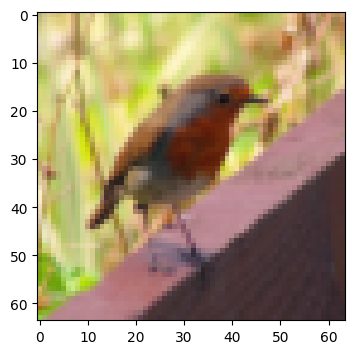

In [8]:
# Example of a picture
index = 10
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

y = [1], it's a 'cat' picture.


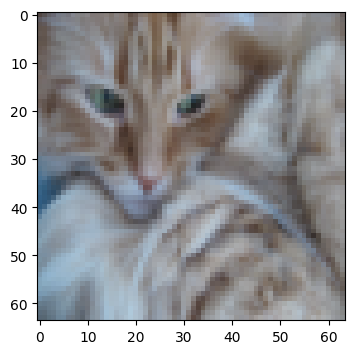

In [9]:
# Example of a picture
index = 2
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

In [10]:
### START CODE HERE ### (≈ 3 lines of code)
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]
### END CODE HERE ###

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


In [11]:
X_train = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T / 255.0
X_test = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T / 255.0

X_train.shape, X_test.shape #(X_train shape (n, m))

((12288, 209), (12288, 50))

In [12]:
Y_train, Y_test = train_set_y, test_set_y
Y_train.shape, Y_test.shape

((1, 209), (1, 50))

In [13]:
# let's define a fn to initialize  parameters
# Note: the first element of the `layer_dims` is the input `X` dims
# Random Initialization (Not recommended for deep networks)

def initialize_parameters(layer_dims: list[int]):
    L = len(layer_dims)
    parameters = {}
    
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.02
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
    
    return parameters

params = initialize_parameters([4, 4, 2, 1])
params

{'W1': array([[-0.03499531,  0.00685361,  0.02306072, -0.00504872],
        [ 0.01962642,  0.01028438,  0.00442359, -0.02140087],
        [-0.00378992,  0.00510003, -0.00916054,  0.00870327],
        [-0.0116719 ,  0.01633694,  0.01345442, -0.00208822]]),
 'b1': array([[0.],
        [0.],
        [0.],
        [0.]]),
 'W2': array([[-0.01062561,  0.02059465, -0.00876271, -0.02236636],
        [ 0.03237963,  0.0308321 , -0.00503758, -0.01684871]]),
 'b2': array([[0.],
        [0.]]),
 'W3': array([[0.00369037, 0.01874164]]),
 'b3': array([[0.]])}

In [14]:
Z = np.random.randn(10, 1)
np.maximum(0, Z)

array([[0.73100034],
       [1.36155613],
       [0.        ],
       [0.05567601],
       [0.22239961],
       [0.        ],
       [0.        ],
       [0.81645401],
       [0.75044476],
       [0.        ]])

In [15]:
# let's define some of the activation functions

def sigmoid(Z):
    return 1. / (1. + np.exp(-Z))

def relu(Z):
    return np.maximum(0, Z)

In [16]:
def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    """
    
    Z = np.dot(W, A) + b
    
    return Z


def linear_activation_forward(A_prev, W, b, activation, layer_num, forward_caches):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer.

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    layer_num -- the current layer number (used to assign keys like 'Z1', 'A1')
    forward_caches -- dictionary to store the forward caches
    """
    
    Z = linear_forward(A_prev, W, b)
    forward_caches['Z' + str(layer_num)] = Z  # Store Z in the cache dictionary
    
    if activation == "sigmoid":
        A = sigmoid(Z)
    elif activation == "relu":
        A = relu(Z)
    
    forward_caches['A' + str(layer_num)] = A  # Store A in the cache dictionary

    return A


def forward_propagation(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- last post-activation value
    forward_caches -- dictionary containing Z and A caches for each layer
    """

    forward_caches = {}  # Dictionary to store Z and A for each layer
    A = X
    L = len(parameters) // 2  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Store Z and A for each layer in the dictionary.
    for l in range(1, L):
        A = linear_activation_forward(A, parameters['W' + str(l)], parameters['b' + str(l)], activation="relu", 
                                        layer_num=l, forward_caches=forward_caches)
    
    # Implement LINEAR -> SIGMOID. Store Z and A for the final layer in the dictionary.
    AL = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation="sigmoid", 
                                    layer_num=L, forward_caches=forward_caches)
    
    return AL, forward_caches

In [17]:
X = np.random.randn(4, 10) * 2.0
AL, forward_caches = forward_propagation(X, params)

In [18]:
AL

array([[0.5       , 0.50001971, 0.50000861, 0.5000122 , 0.50000412,
        0.50000539, 0.50000014, 0.50000594, 0.5       , 0.50000987]])

In [19]:
# let's define the cost function

def compute_cost(AL, Y):
    """
    Computes the cross-entropy cost for binary classification.

    Arguments:
    AL -- Probability vector corresponding to the predicted labels, shape (1, number of examples)
    Y -- True "label" vector (1, number of examples), containing 0 or 1

    Returns:
    cost -- Cross-entropy cost, a scalar value

    The cross-entropy cost is calculated as:
    cost = (-1 / m) * sum(Y * log(AL) + (1 - Y) * log(1 - AL))
    where:
    - AL is the predicted probability vector of the neural network
    - Y is the true label vector
    - m is the number of training examples
    """
    m = Y.shape[1]
    
    first_term = np.sum(Y * np.log(AL))
    second_term = np.sum((1-Y) * np.log(1-AL))
    
    cost = (-1./m) * (first_term + second_term)
    
    return cost

In [20]:
def relu_derivative(Z):
    """
    Derivative of the ReLU activation function.
    """
    dZ = np.where(Z > 0, 1, 0)
    return dZ


def sigmoid_derivative(Z):
    """
    Derivative of the Sigmoid activation function.
    """
    s = 1. / (1. + np.exp(-Z))
    return s * (1 - s)


def activation_derivative(Z, activation="relu"):
    """
    Returns the derivative of the activation function.
    """
    if activation == "relu":
        return relu_derivative(Z)
    elif activation == "sigmoid":
        return sigmoid_derivative(Z)

In [21]:
def compute_gradients(dZ, A_prev, m):
    """
    Implements the backward propagation for a single layer (layer l) for m examples.

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l), shape (n_l, m)
    A_prev -- Activations from the previous layer (or input data), shape (n_l-1, m)
    m -- number of training examples

    Returns:
    dW -- Gradient of the cost with respect to W (current layer l), shape (n_l, n_l-1)
    db -- Gradient of the cost with respect to b (current layer l), shape (n_l, 1)
    """
    dW = (1. / m) * np.dot(dZ, A_prev.T)  # Gradient w.r.t. weights
    db = (1. / m) * np.sum(dZ, axis=1, keepdims=True)  # Gradient w.r.t. bias (average over all examples)

    return dW, db



def backward_propagation(X, Y, AL, forward_caches, parameters):
    """
    Implement the backward propagation for the entire network for m training examples.

    Arguments:
    AL -- Probability vector corresponding to label predictions, shape (1, m)
    Y -- True "label" vector (1, m)
    forward_caches -- Dictionary containing Z and A caches from forward propagation
    parameters -- Dictionary containing W and b parameters for each layer

    Returns:
    grads -- Dictionary containing gradients dW and db for each layer
    """
    
    grads = {}
    L = len(parameters) // 2  # number of layers
    m = Y.shape[1]  # number of examples
    
    # Initializing the backpropagation
    dZL = AL - Y  # For the output layer, dZL = A[L] - Y

    # Lth layer (SIGMOID -> LINEAR) gradients
    A_prev = forward_caches['A' + str(L-1)]
    grads["dW" + str(L)], grads["db" + str(L)] = compute_gradients(dZL, A_prev, m=m)

    # Loop over the layers backward, starting from L-1 to 1
    for l in reversed(range(1, L)):
        dZ = np.dot(parameters['W' + str(l+1)].T, dZL) * activation_derivative(forward_caches['Z' + str(l)], 
                                                                                activation="relu")
        A_prev = forward_caches['A' + str(l-1)] if l > 1 else X  # A_prev for layer 1 is input X
        
        grads["dW" + str(l)], grads["db" + str(l)] = compute_gradients(dZ, A_prev, m=m)
        dZL = dZ  # Update dZL for the next layer
    
    return grads

In [22]:
def gradient_descent(parameters, gradients, lr=0.001):
    
    """
    Updates parameters for an L-layer neural network using gradient descent.

    Arguments:
    parameters -- Python dictionary containing the parameters "W1", "b1", ..., "WL", "bL"
    gradients -- Python dictionary containing the gradients "dW1", "db1", ..., "dWL", "dbL"
    lr -- Learning rate (default is 0.001)

    Returns:
    parameters -- Python dictionary containing the updated parameters
    """
    
    L = len(parameters) // 2  # number of layers in the neural network
    
    # Update rule for each parameter using gradient descent
    for l in range(1, L+1):
        parameters['W' + str(l)] = parameters['W' + str(l)] - (lr * gradients['dW' + str(l)])
        parameters['b' + str(l)] = parameters['b' + str(l)] - (lr * gradients['db' + str(l)])
        
    return parameters

In [23]:
def initialize_velocity(parameters):
    """
    Initializes the velocity as a python dictionary with:
                - keys: "dW1", "db1", ..., "dWL", "dbL" 
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
    Arguments:
    parameters -- python dictionary containing your parameters.
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    
    Returns:
    v -- python dictionary containing the current velocity.
                    v['dW' + str(l)] = velocity of dWl
                    v['db' + str(l)] = velocity of dbl
    """
    
    L = len(parameters) // 2    # number of layers in the neural networks
    v = {}
    
    # Initialize velocity
    for l in range(1, L+1):
        v["dW" + str(l)] = np.zeros(parameters['W' + str(l)].shape)
        v["db" + str(l)] = np.zeros(parameters['b' + str(l)].shape)
        
    return v

In [24]:
# initialize_velocity(params)

In [25]:
def momentum(parameters, grads, v, beta, learning_rate):
    """
    Update parameters using Momentum
    
    Arguments:
    parameters -- python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    v -- python dictionary containing the current velocity:
                    v['dW' + str(l)] = ...
                    v['db' + str(l)] = ...
    beta -- the momentum hyperparameter, scalar
    learning_rate -- the learning rate, scalar
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    v -- python dictionary containing your updated velocities
    """

    L = len(parameters) // 2    # number of layers in the neural networks
    
    # Momentum update for each parameter
    for l in range(1, L+1):
        
        # compute velocities
        v["dW" + str(l)] = beta * v["dW" + str(l)] + (1 - beta) * grads['dW' + str(l)]
        v["db" + str(l)] = beta * v["db" + str(l)] + (1 - beta) * grads['db' + str(l)]
        
        # update parameters
        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * v["dW" + str(l)]
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * v["db" + str(l)]
        
    return parameters

In [26]:
def RMSProp(parameters, grads, s, beta1, learning_rate, epsilon=1e-8):
    
    L = len(parameters) // 2
    
    for l in range(1, L+1):
        
        # compute the velocities
        s["dW" + str(l)] = beta1 * s["dW" + str(l)] + (1 - beta1) * np.square(grads['dW' + str(l)])
        s["db" + str(l)] = beta1 * s["db" + str(l)] + (1 - beta1) * np.square(grads['db' + str(l)])
        
        # update parameters
        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * ( grads["dW" + str(l)] / ( np.sqrt(s["dW" + str(l)]) + epsilon ) )
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * ( grads["db" + str(l)] / ( np.sqrt(s["db" + str(l)]) + epsilon ) )
    
    return parameters

In [27]:
def initialize_adam(parameters):
    
    """
    Initializes v and s as two python dictionaries with:
                - keys: "dW1", "db1", ..., "dWL", "dbL" 
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
    
    Arguments:
    parameters -- python dictionary containing your parameters.
                    parameters["W" + str(l)] = Wl
                    parameters["b" + str(l)] = bl
    
    Returns: 
    v -- python dictionary that will contain the exponentially weighted average of the gradient.
                    v["dW" + str(l)] = ...
                    v["db" + str(l)] = ...
    s -- python dictionary that will contain the exponentially weighted average of the squared gradient.
                    s["dW" + str(l)] = ...
                    s["db" + str(l)] = ...

    """
    
    L = len(parameters) // 2    # number of layers in the neural networks
    v = {}
    s = {}
    
    # Initialize v, s. Input: "parameters". Outputs: "v, s".
    for l in range(1, L+1):
        
        v["dW" + str(l)] = np.zeros(parameters["W" + str(l)].shape)
        v["db" + str(l)] = np.zeros(parameters["b" + str(l)].shape)
        s["dW" + str(l)] = np.zeros(parameters["W" + str(l)].shape)
        s["db" + str(l)] = np.zeros(parameters["b" + str(l)].shape)
    
    return v, s


def Adam(parameters, grads, v, s, t, learning_rate=0.01,
                                beta1=0.9, beta2=0.999, epsilon=1e-8):
    
    """
    Update parameters using Adam
    
    Arguments:
    parameters -- python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    learning_rate -- the learning rate, scalar.
    beta1 -- Exponential decay hyperparameter for the first moment estimates 
    beta2 -- Exponential decay hyperparameter for the second moment estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates

    Returns:
    parameters -- python dictionary containing your updated parameters 
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    """
    
    L = len(parameters) // 2                 # number of layers in the neural networks
    v_corrected = {}                         # Initializing first moment estimate, python dictionary
    s_corrected = {}                         # Initializing second moment estimate, python dictionary
    
    # Perform Adam update on all parameters
    for l in range(1, L+1):
        # Moving average of the gradients. Inputs: "v, grads, beta1". Output: "v".
        v["dW" + str(l)] = beta1 * v["dW" + str(l)] + (1 - beta1) * grads['dW' + str(l)]
        v["db" + str(l)] = beta1 * v["db" + str(l)] + (1 - beta1) * grads['db' + str(l)]

        # Compute bias-corrected first moment estimate. Inputs: "v, beta1, t". Output: "v_corrected".
        v_corrected["dW" + str(l)] = v["dW" + str(l)] / (1 - np.power(beta1, t))
        v_corrected["db" + str(l)] = v["db" + str(l)] / (1 - np.power(beta1, t))

        # Moving average of the squared gradients. Inputs: "s, grads, beta2". Output: "s".
        s["dW" + str(l)] = beta2 * s["dW" + str(l)] + (1 - beta2) * np.square(grads['dW' + str(l)])
        s["db" + str(l)] = beta2 * s["db" + str(l)] + (1 - beta2) * np.square(grads['db' + str(l)])

        # Compute bias-corrected second raw moment estimate. Inputs: "s, beta2, t". Output: "s_corrected".
        s_corrected["dW" + str(l)] = s["dW" + str(l)] / (1 - np.power(beta2, t))
        s_corrected["db" + str(l)] = s["db" + str(l)] / (1 - np.power(beta2, t))

        # Update parameters. Inputs: "parameters, learning_rate, v_corrected, s_corrected, epsilon". Output: "parameters".
        parameters["W" + str(l)] = parameters['W' + str(l)] - learning_rate *  ( v_corrected["dW" + str(l)] / (np.sqrt(s_corrected["dW" + str(l)] + epsilon)) )
        parameters["b" + str(l)] = parameters['b' + str(l)] - learning_rate *  ( v_corrected["db" + str(l)] / (np.sqrt(s_corrected["db" + str(l)] + epsilon)) )

    return parameters

In [28]:
def update_parameters(parameters, grads, v, s, beta, beta1, beta2, learning_rate, t, optimizer):
    
    if optimizer == 'momentum':
        parameters = momentum(parameters=parameters, grads=grads, 
                                    v=v, beta=beta, learning_rate=learning_rate)
        return parameters
    
    elif optimizer == 'RMSProp':
        parameters = RMSProp(parameters=parameters, grads=grads, 
                                s=v, beta1=beta1, learning_rate=learning_rate)
        return parameters
    
    elif optimizer == 'Adam':
        t += 1
        parameters = Adam(parameters=parameters, grads=grads, v=v, s=s,
                            beta1=beta1, beta2=beta2, t=t, learning_rate=learning_rate)
        return parameters
    
    elif optimizer == 'gd':
        parameters = gradient_descent(parameters=parameters, gradients=grads, lr=learning_rate)
        return parameters

In [29]:

def nn_model(layer_dims, X_train, Y_train, X_test, Y_test,
                num_iterations, lr, beta, beta1, beta2, optimizer, print_cost=True):
    
    parameters = initialize_parameters(layer_dims)
    # v = initialize_velocity(parameters=parameters)
    v, s = initialize_adam(parameters=parameters)
    
    costs, test_costs = [], []

    for i in range(num_iterations):
        # Forward propagation. 
        AL, forward_caches = forward_propagation(X=X_train, parameters=parameters)
        
        
        # Cost function
        cost = compute_cost(AL=AL, Y=Y_train)
        
        # Backpropagation. Inputs: "parameters, cache, X, Y". Outputs: "grads".
        gradients = backward_propagation(X=X_train, 
                                    Y=Y_train,
                                    AL=AL,
                                    forward_caches=forward_caches,
                                    parameters=parameters)
        
        
        # inferences
        AL_test, _ = forward_propagation(X=X_test, parameters=parameters)
        cost_test = compute_cost(AL=AL_test, Y=Y_test)
        
        
        # Print the cost every 500 iterations
        if print_cost and (i % 500 == 0):
            print(f"Training cost at {i}th iteration is: {cost}")
            print(f"Test cost at {i}th iteration is: {cost_test}\n")
        
        
        # Gradient descent parameter update with advanced optimizer
        parameters = update_parameters(parameters=parameters, 
                                    grads=gradients, 
                                    learning_rate=lr,
                                    v=v,
                                    s=s,
                                    beta=beta,
                                    beta1=beta1,
                                    beta2=beta2,
                                    t=i,
                                    optimizer=optimizer)
        
        costs.append(cost)
        test_costs.append(cost_test)

    return parameters, costs, test_costs

In [30]:
nx, ny = X_train.shape[0], Y_train.shape[0]
nx, ny

(12288, 1)

In [55]:
%%time

layer_dims = [nx, 8, 4, ny]
n_iterations = 8000

opt_params, costs, test_costs = nn_model(
    layer_dims=layer_dims,
    X_train=X_train,
    Y_train=Y_train,
    X_test=X_test,
    Y_test=Y_test,
    num_iterations=n_iterations,
    lr=0.01,
    beta=0.9,
    beta1=0.9,
    beta2=0.999,
    optimizer='gd' # gradient descent optimizer
)

Training cost at 0th iteration is: 0.6931574800008742
Test cost at 0th iteration is: 0.6931492572986524

Training cost at 500th iteration is: 0.6484286323091892
Test cost at 500th iteration is: 0.7893019027952438

Training cost at 1000th iteration is: 0.6444060625211357
Test cost at 1000th iteration is: 0.8277177732445955

Training cost at 1500th iteration is: 0.6440057862947824
Test cost at 1500th iteration is: 0.8406660072825288

Training cost at 2000th iteration is: 0.6439587733256171
Test cost at 2000th iteration is: 0.8448900962338931

Training cost at 2500th iteration is: 0.6439442945606856
Test cost at 2500th iteration is: 0.8462552877807176

Training cost at 3000th iteration is: 0.6439259948315776
Test cost at 3000th iteration is: 0.8466861249455941

Training cost at 3500th iteration is: 0.6438907978754936
Test cost at 3500th iteration is: 0.8468123114673739

Training cost at 4000th iteration is: 0.6438054729039617
Test cost at 4000th iteration is: 0.8468342004997922

Training 

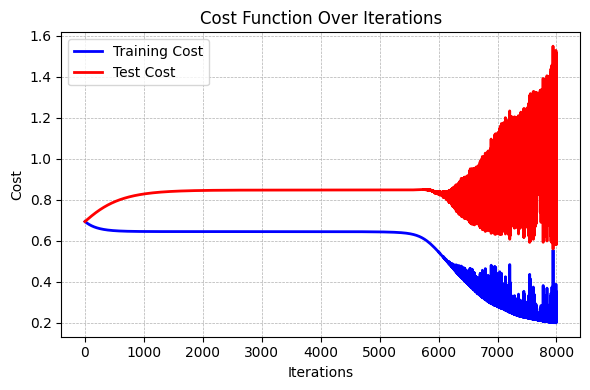

In [56]:
plot_cost_over_iterations(n_iterations=n_iterations, 
                            train_costs=costs, test_costs=test_costs)

In [57]:
_, train_acc = predict(X_train, Y_train, opt_params)
print(f"Training accuracy: {train_acc}")

Training accuracy: 93.30143540669856


In [58]:
_, test_acc = predict(X_test, Y_test, opt_params)
print(f"Test accuracy: {test_acc}")

Test accuracy: 72.0


In [51]:
%%time

layer_dims = [nx, 8, 4, ny]
n_iterations = 8000

opt_params_momentum, costs_momentum, test_costs_momentum = nn_model(
    layer_dims=layer_dims,
    X_train=X_train,
    Y_train=Y_train,
    X_test=X_test,
    Y_test=Y_test,
    num_iterations=n_iterations,
    lr=0.01,
    beta=0.9,
    beta1=0.9,
    beta2=0.999,
    optimizer='momentum' # gradient descent with momentum optimizer
)

Training cost at 0th iteration is: 0.6931387226598464
Test cost at 0th iteration is: 0.6931768975673614

Training cost at 500th iteration is: 0.6483815714610788
Test cost at 500th iteration is: 0.789771642923705

Training cost at 1000th iteration is: 0.6443933598383149
Test cost at 1000th iteration is: 0.8284885673809015

Training cost at 1500th iteration is: 0.6440042577854944
Test cost at 1500th iteration is: 0.841100475189533

Training cost at 2000th iteration is: 0.643937448765148
Test cost at 2000th iteration is: 0.8451114349526168

Training cost at 2500th iteration is: 0.643855284425378
Test cost at 2500th iteration is: 0.8463197668474584

Training cost at 3000th iteration is: 0.6436124635247358
Test cost at 3000th iteration is: 0.8464773584585114

Training cost at 3500th iteration is: 0.6427541185769721
Test cost at 3500th iteration is: 0.8461538573304783

Training cost at 4000th iteration is: 0.6373866114553459
Test cost at 4000th iteration is: 0.84547368450494

Training cost a

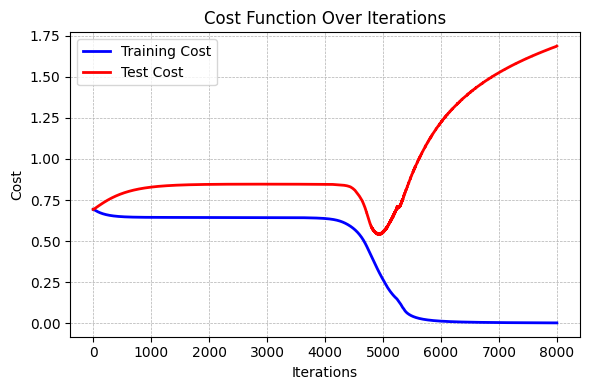

In [52]:
plot_cost_over_iterations(n_iterations=n_iterations, 
                            train_costs=costs_momentum, test_costs=test_costs_momentum)

In [53]:
_, train_acc = predict(X_train, Y_train, opt_params_momentum)
print(f"Training accuracy: {train_acc}")

Training accuracy: 100.0


In [54]:
_, test_acc = predict(X_test, Y_test, opt_params_momentum)
print(f"Test accuracy: {test_acc}")

Test accuracy: 74.0


In [64]:
%%time

layer_dims = [nx, 8, 4, ny]
n_iterations = 4000

opt_params_rmsprop, costs_rmsprop, test_costs_rmsprop = nn_model(
    layer_dims=layer_dims,
    X_train=X_train,
    Y_train=Y_train,
    X_test=X_test,
    Y_test=Y_test,
    num_iterations=n_iterations,
    lr=0.0001,
    beta=0.99,
    beta1=0.99,
    beta2=0.999,
    optimizer='RMSProp' # RMSProp optimizer
)

Training cost at 0th iteration is: 0.6931225211156143
Test cost at 0th iteration is: 0.6932037987660552

Training cost at 500th iteration is: 0.5091667293623898
Test cost at 500th iteration is: 0.7451405951327646

Training cost at 1000th iteration is: 0.3669545658476123
Test cost at 1000th iteration is: 0.7794570844340912

Training cost at 1500th iteration is: 0.2841991272695237
Test cost at 1500th iteration is: 0.9153528749082684

Training cost at 2000th iteration is: 0.23561874187750326
Test cost at 2000th iteration is: 1.1269470013491298

Training cost at 2500th iteration is: 0.2078443945153318
Test cost at 2500th iteration is: 1.39065006617044

Training cost at 3000th iteration is: 0.07902752053971235
Test cost at 3000th iteration is: 1.514834269776916

Training cost at 3500th iteration is: 0.032928288327017934
Test cost at 3500th iteration is: 1.7912930345572944

CPU times: total: 1min 18s
Wall time: 21.3 s


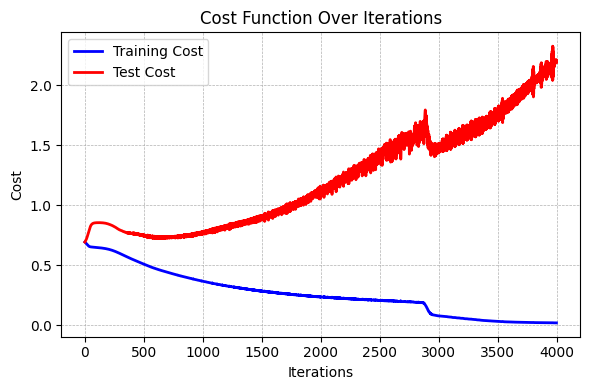

In [65]:
plot_cost_over_iterations(n_iterations=n_iterations, 
                            train_costs=costs_rmsprop, test_costs=test_costs_rmsprop)

In [66]:
_, train_acc = predict(X_train, Y_train, opt_params_rmsprop)
print(f"Training accuracy: {train_acc}")

Training accuracy: 98.08612440191388


In [67]:
_, test_acc = predict(X_test, Y_test, opt_params_rmsprop)
print(f"Test accuracy: {test_acc}")

Test accuracy: 66.0


In [69]:
%%time

layer_dims = [nx, 8, 4, ny]
n_iterations = 4000

opt_params_adam, costs_adam, test_costs_adam = nn_model(
    layer_dims=layer_dims,
    X_train=X_train,
    Y_train=Y_train,
    X_test=X_test,
    Y_test=Y_test,
    num_iterations=n_iterations,
    lr=0.001,
    beta=0.9,
    beta1=0.9,
    beta2=0.999,
    optimizer='Adam' # Adam optimizer
)

Training cost at 0th iteration is: 0.693121213546907
Test cost at 0th iteration is: 0.693178807143283

Training cost at 500th iteration is: 0.17059700382241066
Test cost at 500th iteration is: 1.4137619458036905

Training cost at 1000th iteration is: 0.11535895538720924
Test cost at 1000th iteration is: 1.5300847189607487

Training cost at 1500th iteration is: 0.08207473770986437
Test cost at 1500th iteration is: 1.6184737231180202

Training cost at 2000th iteration is: 0.060232342351624876
Test cost at 2000th iteration is: 1.843830466878127

Training cost at 2500th iteration is: 0.045239373167507584
Test cost at 2500th iteration is: 1.8654263730927962

Training cost at 3000th iteration is: 0.03457219388150508
Test cost at 3000th iteration is: 1.9384145401444393

Training cost at 3500th iteration is: 0.026810873484991303
Test cost at 3500th iteration is: 1.686878251589068

CPU times: total: 1min 31s
Wall time: 24.7 s


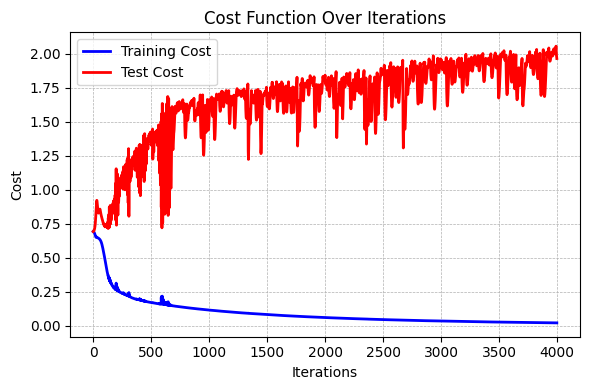

In [70]:
plot_cost_over_iterations(n_iterations=n_iterations, 
                            train_costs=costs_adam, test_costs=test_costs_adam)

In [71]:
_, train_acc = predict(X_train, Y_train, opt_params_adam)
print(f"Training accuracy: {train_acc}")

Training accuracy: 100.0


In [72]:
_, test_acc = predict(X_test, Y_test, opt_params_adam)
print(f"Test accuracy: {test_acc}")

Test accuracy: 66.0
